**Instructions:** replace the string in the second cell, and execute each cell (to execute a cell, hit `Shift+Enter`)

In [1]:
import numpy as np
#%matplotlib notebook
%matplotlib widget
# or `%matplotlib inline` for non-interactive plots
# or `%matplotlib widget` when using JupyterLab (github.com/matplotlib/jupyter-matplotlib)
import matplotlib.pyplot as plt
from openpmd_viewer import OpenPMDTimeSeries

In [2]:
import matplotlib as mpl
import matplotlib.animation as animation

In [3]:
# Replace the string below, to point to your data
ts = OpenPMDTimeSeries('./Simulation Data/diags/hdf5/')

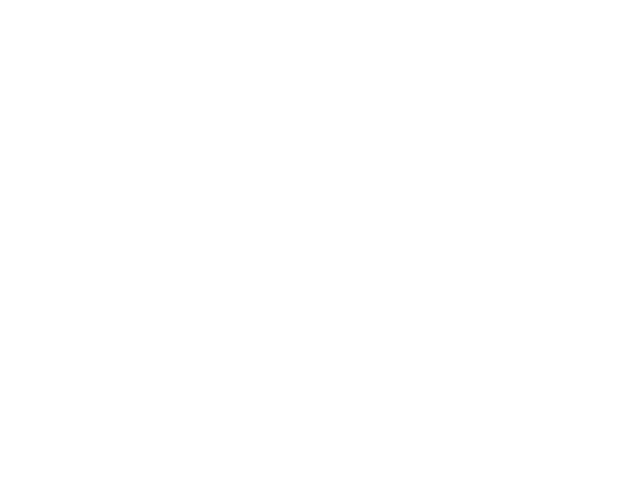

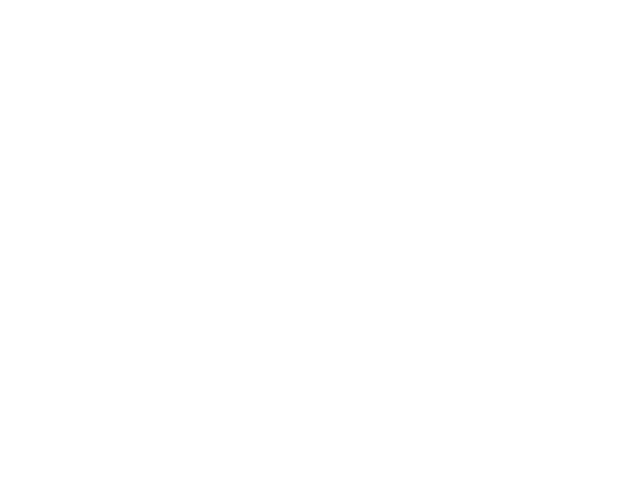

In [4]:
# Interactive GUI
ts.slider()

# Animate Result

In [7]:
field = 'rho'
coord = None

In [8]:
t = ts.t[74]

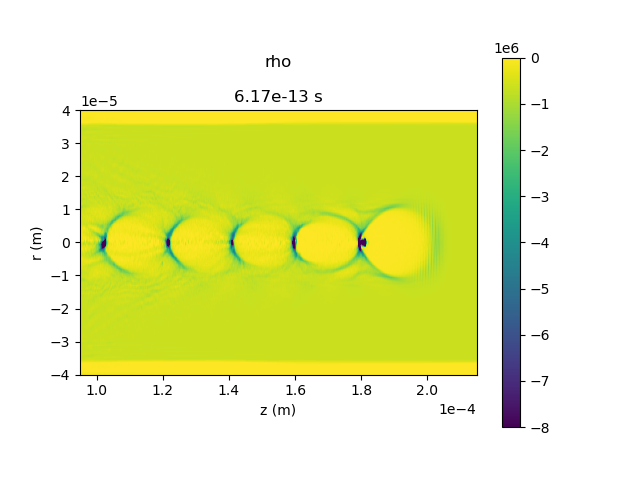

In [9]:
Ex, info_Ex = ts.get_field(t=t, field=field, coord=coord)

fig, ax = plt.subplots()
im = ax.imshow(Ex, aspect=1, extent=info_Ex.imshow_extent)

# Set color bar limit--may want to remove this if plotting different things
im.set_clim(-8e6, 0)

if coord is None:
    ax.set_title("{0}\n\n{1:.3g} s".format(field, t))
else:
    ax.set_title("{0}_{1}\n\n{2:.3g} s".format(field, coord, t))
ax.set_xlabel('z (m)')
ax.set_ylabel('r (m)')

ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

fig.colorbar(im, ax=ax)

#fig.savefig("Graphics/{0}_{1}_{2}_s.png".format(field, coord, t))

In [10]:
def update_anim(i):
    Ex, info_Ex = ts.get_field(t=ts.t[i], field=field, coord=coord)
    im.set_array(Ex)
    im.set_extent(info_Ex.imshow_extent)
    if coord is None:
        ax.set_title("{0}\n\n{1:.3g} s".format(field, ts.t[i]))
    else:
        ax.set_title("{0}_{1}\n\n{2:.3g} s".format(field, coord, ts.t[i]))
    return im, 

In [236]:
animation_fig = animation.FuncAnimation(fig, update_anim, frames=len(ts.t), interval=100, blit=True, repeat=False, repeat_delay=1000)

In [237]:
animation_fig.save('laser.gif'.format(field, coord))

# Electron Momentum

### Bin the particles

In [91]:
def bin(data, weights, nbins=100):
    # Set up the bins
    bin_width = (np.max(data) - np.min(data))/nbins
    bins = np.arange(np.min(data), np.max(data), bin_width)
    
    counts = np.zeros(nbins)
    
    for i, bin_id in enumerate(np.digitize(data, bins)):
        counts[bin_id-1] += weights[i]
    
    return bins, counts

In [92]:
def bin2d(datax, datay, weights, nbins=100):
    if datax.size==0:
        return np.zeros(nbins), np.zeros(nbins), np.zeros((nbins,nbins))
    
    # Set up the bins
    bin_width = (np.max(datax)-np.min(datax))/nbins
    bin_height = (np.max(datay)-np.min(datay))/nbins
    
    bins_x = np.arange(np.min(datax), np.max(datax), bin_width)
    bins_y = np.arange(np.min(datay), np.max(datay), bin_height)
    
    # Sort macro particles into bins
    indices_x = np.digitize(datax, bins_x)
    indices_y = np.digitize(datay, bins_y)
    
    # Add weights of each macro particle into its bin
    counts = np.zeros((nbins, nbins))
    
    for i, particle_weight in enumerate(weights):
            counts[nbins-indices_y[i]][indices_x[i]-1] += particle_weight
    
    return bins_x, bins_y, counts

### Animated Figure

In [93]:
nbins = 300

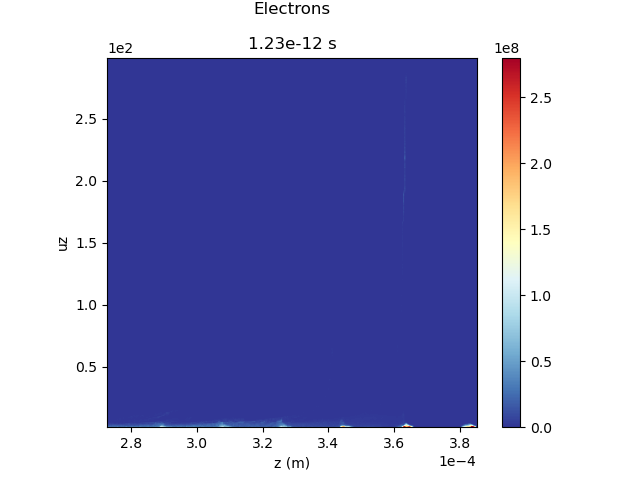

In [94]:
z, uz, w = ts.get_particle(species='electrons', var_list=['z', 'uz', 'w'], t=ts.t[-1])

bins_x, bins_y, counts = bin2d(z, uz, w, nbins=nbins)

fig, ax = plt.subplots()
im = ax.imshow(counts, cmap=mpl.colormaps['RdYlBu_r'], extent=[bins_x[0], bins_x[-1], bins_y[0], bins_y[-1]], aspect=(bins_x[-1]-bins_x[0])/(bins_y[-1]-bins_y[0]))

ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

ax.set_title('Electrons\n\n{0:.3g} s'.format(ts.t[-1]))
ax.set_xlabel('z (m)')
ax.set_ylabel('uz')

fig.colorbar(im, ax=ax)

fig.savefig("Electrons last frame.png")

In [264]:
def update_anim_electrons(i):
    z, uz, w = ts.get_particle(species='electrons', var_list=['z', 'uz', 'w'], t=ts.t[i])
    
    if z.size == 0:
        im.set_array(np.zeros((nbins, nbins)))
        return im, 
    
    bins_x, bins_y, counts = bin2d(z, uz, w, nbins=nbins)

    im.set_extent([bins_x[0], bins_x[-1], bins_y[0], bins_y[-1]])
    ax.set_aspect((bins_x[-1]-bins_x[0])/(bins_y[-1]-bins_y[0]))
    
    ax.set_title('Electrons\n\n{0:.3g} s'.format(ts.t[i]))
    
    im.set_array(counts)

    return im, 

In [265]:
animation_fig = animation.FuncAnimation(fig, update_anim_electrons, frames=len(ts.t), interval=100, blit=True, repeat=False, repeat_delay=1000)

In [266]:
animation_fig.save('electrons.gif')